In [1]:
import torch

# Vérifie si CUDA est disponible
if torch.cuda.is_available():
    # Affiche le nombre de GPUs disponibles
    print(f"Nombre de GPUs disponibles: {torch.cuda.device_count()}")
    # Affiche le nom du GPU actif
    print(f"GPU actif: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA n'est pas disponible. Utilisez le CPU.")


Nombre de GPUs disponibles: 1
GPU actif: NVIDIA GeForce RTX 2060


In [2]:
import tensorflow as tf

# Liste les dispositifs physiques (CPU, GPU)
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    # Active le mode de mémoire croissante (utile si vous avez plusieurs GPUs)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU disponible")
else:
    print("Aucun GPU disponible. Utilisez le CPU.")


GPU disponible


In [3]:
if len(tf.config.list_physical_devices('GPU'))>0:
    print('GPU disponible')
else:
    print("GPU non disponible")

GPU disponible


In [4]:
import numpy as np
from PIL import Image
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Charger le dataset MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalisation et redimensionnement des images
x_train = np.expand_dims(x_train, axis=-1) / 255.
x_test = np.expand_dims(x_test, axis=-1) / 255.

# Simulation d'images de basse résolution
def degrade_images(images, scale_factor=2):
    images_hr = images
    images_lr = np.array([np.array(Image.fromarray(img.squeeze(-1)).resize((img.shape[0]//scale_factor, img.shape[1]//scale_factor), Image.BICUBIC)) for img in images])
    images_lr = np.expand_dims(images_lr, axis=-1)
    return images_lr, images_hr

x_train_lr, x_train_hr = degrade_images(x_train)
x_test_lr, x_test_hr = degrade_images(x_test)


In [5]:
from tensorflow.keras.layers import Conv2D, Input, UpSampling2D
from tensorflow.keras.models import Model

def build_srcnn(input_shape=(None, None, 1)):
    input_img = Input(shape=input_shape)
    
    # Upsampling pour augmenter la résolution de l'image
    x = UpSampling2D(size=(2, 2))(input_img)
    x = Conv2D(64, (9, 9), activation='relu', padding='same')(x)
    x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    x = Conv2D(1, (5, 5), activation='linear', padding='same')(x)

    model = Model(input_img, x)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

srcnn = build_srcnn(input_shape=(14, 14, 1))
srcnn.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 28, 28, 1)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        5248      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        2080      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         801       
                                                                 
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
___________________________________________________________

In [6]:
srcnn.fit(x_train_lr, x_train_hr, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10
1688/1688 [==============================] - 15s 8ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 2/10
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3/10
1688/1688 [==============================] - 14s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 4/10
1688/1688 [==============================] - 13s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/10
1688/1688 [==============================] - 13s 8ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 6/10
1688/1688 [==============================] - 16s 10ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/10
1688/1688 [==============================] - 14s 9ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/10
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/10
1688/1688 [==============================] - 11s 7ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 10/10
1688/1688 [==============================] - 11s 7ms/step - 

313/313 [==============================] - 1s 4ms/step


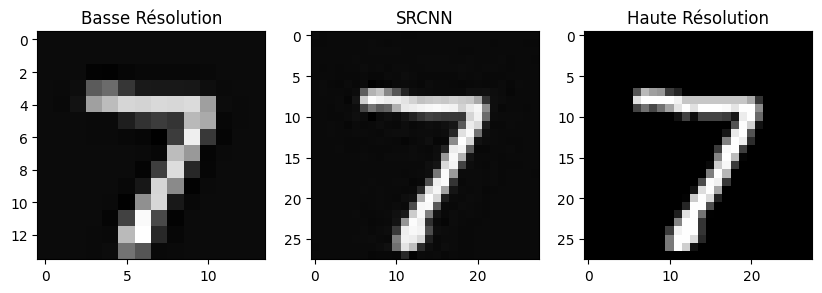

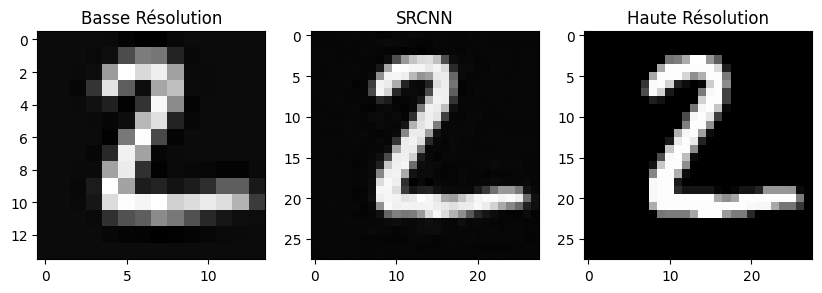

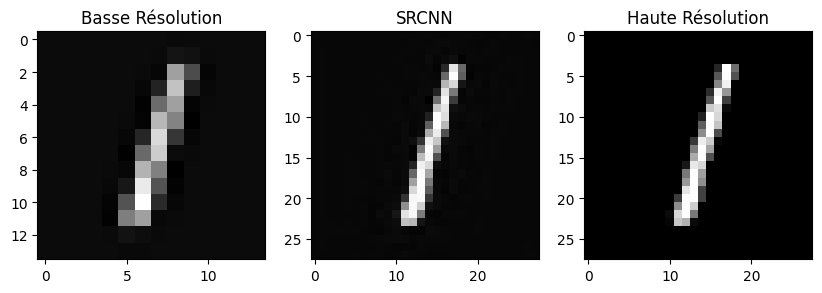

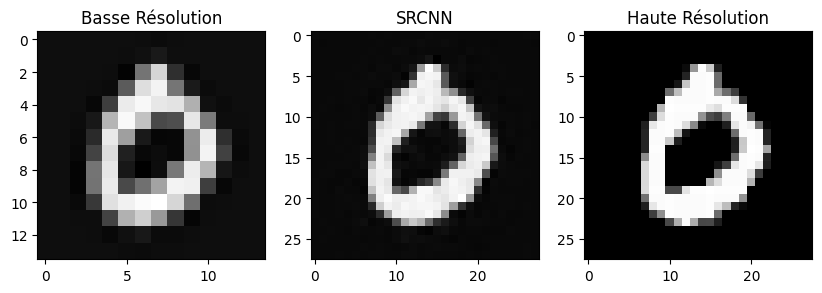

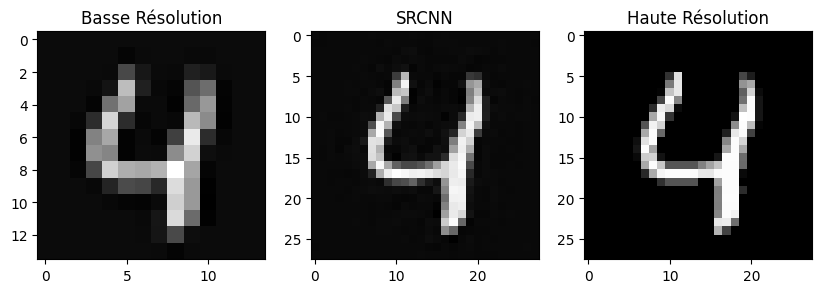

In [10]:
import matplotlib.pyplot as plt

# Prédiction sur l'ensemble de test
predicted = srcnn.predict(x_test_lr)

# Afficher quelques images
for i in range(5):
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(x_test_lr[i].squeeze(), cmap='gray')
    plt.title("Basse Résolution")
    plt.subplot(1, 3, 2)
    plt.imshow(predicted[i].squeeze(), cmap='gray')
    plt.title("SRCNN")
    plt.subplot(1, 3, 3)
    plt.imshow(x_test_hr[i].squeeze(), cmap='gray')
    plt.title("Haute Résolution")
    plt.show()
